## Milestone 3 - First Model Training and Evaluation

#### Dependencies to install

In [1]:
!pip install ucimlrepo -q

#### Imports

In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier as Dtree
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

#### Fetching data

In [3]:
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

####Preprocessing (Dropping duplicates, Min-Max Scaling)


In [4]:
dataset = pd.concat([X, y], axis=1)
print(dataset.isnull().sum(),'\n')
print('Number of duplicates:', dataset.duplicated().sum())

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
Diabetes_binary         0
dtype: int64 

Number of duplicates: 24206


In [5]:
dataset = dataset.drop_duplicates()

X = dataset[X.columns]
y = dataset[y.columns]

#### Total observations in dataset

In [6]:
print('Number of rows in features dataset:', len(X))
print('Number of rows in target dataset:', len(y))

Number of rows in features dataset: 229474
Number of rows in target dataset: 229474


In [7]:
X[['BMI', 'GenHlth', 'MentHlth', 'PhysHlth' , 'Age', 'Education', 'Income']]

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
0,40,5,18,15,9,4,3
1,25,3,0,0,7,6,1
2,28,5,30,30,9,4,8
3,27,2,0,0,11,3,6
4,24,2,3,0,11,5,4
...,...,...,...,...,...,...,...
253675,45,3,0,5,5,6,7
253676,18,4,0,0,11,2,4
253677,28,1,0,0,2,5,2
253678,23,3,0,0,7,5,1


Correlation Matrix

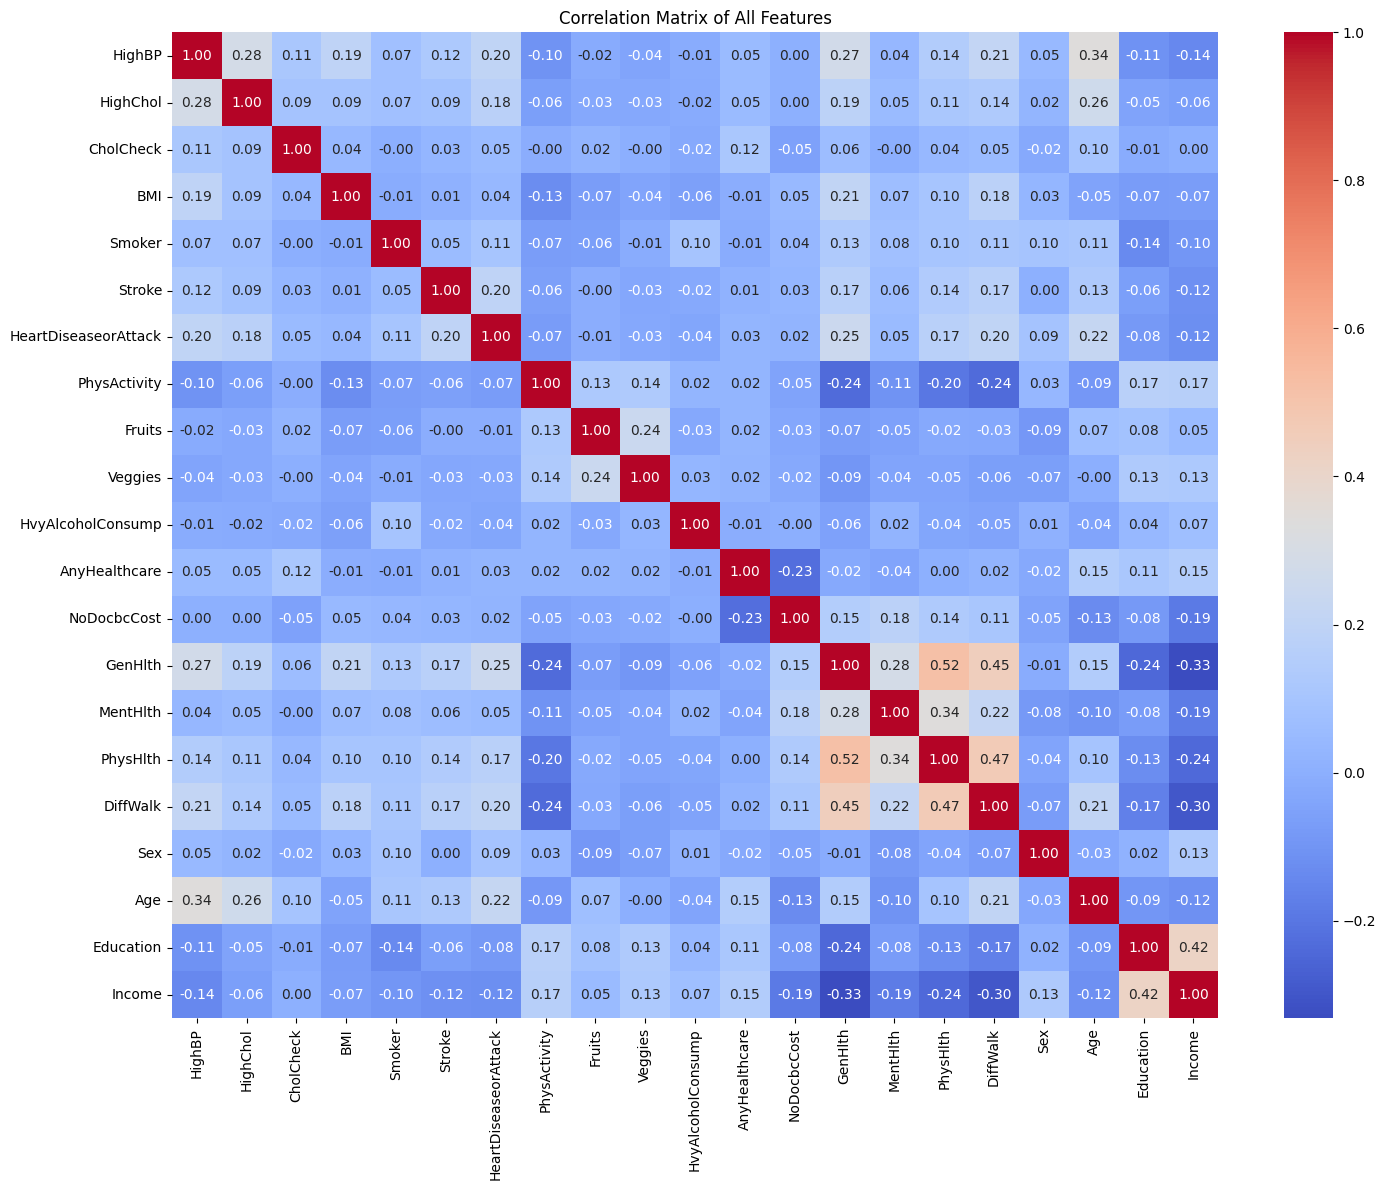

In [8]:
corr_matrix = X.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of All Features')
plt.tight_layout()
plt.show()

Based on the correlation matrix above, it seems that many of the features are not too correlated with other. Because of this, we will be moving forward with all of our feature columns when we train our model. We can later look at the trained model and check if any of the features were not really used in training.

Based on the EDA done above, features 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', and 'Income' are not categorical. Just to have everything scaled to a 0-1 value, we will apply Min-Max standardization for these features.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cols_to_scale = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

scaler = MinMaxScaler()
scaler.fit(X_train[cols_to_scale])

X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Training Decision Tree with Imbalanced Data

In [10]:
dt = Dtree(random_state=42)
dt.fit(X_train, y_train)

print("Model performance on Train data:")
y_pred_train = dt.predict(X_train)
print(classification_report(y_train, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))

print("_____________________________________________________________")

print("Model performance on Test data:")
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Model performance on Train data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    155501
           1       1.00      0.96      0.98     28078

    accuracy                           0.99    183579
   macro avg       1.00      0.98      0.99    183579
weighted avg       0.99      0.99      0.99    183579

Confusion Matrix:
 [[155501      0]
 [   993  27085]]
_____________________________________________________________
Model performance on Test data:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     38876
           1       0.29      0.32      0.30      7019

    accuracy                           0.77     45895
   macro avg       0.58      0.59      0.58     45895
weighted avg       0.78      0.77      0.78     45895

Confusion Matrix:
 [[33256  5620]
 [ 4768  2251]]


These results from the initial Decision Tree model (trained on the imbalanced data) demonstrates overfitting. The model has a 99% accuracy on the training data and only a 77% accuracy on the unseen test data. The model is failing to predict the positive class (Class 1, diabetes) and achieving a very poor recall of 0.32 and precision of 0.29. This means the model is only correctly identifying 32% of the actual diabetes cases in the test set. Next, we will oversample the data to try to balance it more, and then see if that helped the model.

## Training Decision Trees with Balanced data (Oversampling)

In [11]:
ros = RandomOverSampler(random_state=42)

X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("Before Oversampling: ")
print(y_train.value_counts())
print("After Oversampling: ")
print(y_train_res.value_counts())

Before Oversampling: 
Diabetes_binary
0                  155501
1                   28078
Name: count, dtype: int64
After Oversampling: 
Diabetes_binary
0                  155501
1                  155501
Name: count, dtype: int64


In [12]:
dt = Dtree(random_state=42)
dt.fit(X_train_res, y_train_res)

print("Model performance on Train data:")
y_pred_train = dt.predict(X_train_res)
print(classification_report(y_train_res, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train_res, y_pred_train))

print("_____________________________________________________________")

print("Model performance on Test data:")
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Model performance on Train data:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    155501
           1       0.99      1.00      1.00    155501

    accuracy                           1.00    311002
   macro avg       1.00      1.00      1.00    311002
weighted avg       1.00      1.00      1.00    311002

Confusion Matrix:
 [[154514    987]
 [     6 155495]]
_____________________________________________________________
Model performance on Test data:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     38876
           1       0.27      0.28      0.28      7019

    accuracy                           0.78     45895
   macro avg       0.57      0.57      0.57     45895
weighted avg       0.78      0.78      0.78     45895

Confusion Matrix:
 [[33598  5278]
 [ 5024  1995]]


Applying oversampling didn't fix the problem and actually made the model's performance slightly worse. The training results show the model is  even more overfit than before. It achieved a 100% accuracy on the balanced training set, and the accuracy only went up a little bit to 78% on the testing set compared to the previous model. The model's ability to find the minority class (Class 1, diabetes) worsened, with the recall dropping from 0.32 down to 0.28. This means the model is still failing to identify over 70% of the actual diabetes cases, indicating simply oversampling was not the right solution.

## Hyperparameter Tuning



In [ ]:
dt_tuned = Dtree(max_depth=10, min_samples_leaf=20, random_state=42)
dt_tuned.fit(X_train_res, y_train_res)

print("Model performance on Train data (Resampled):")
y_pred_train_tuned = dt_tuned.predict(X_train_res)
print(classification_report(y_train_res, y_pred_train_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_train_res, y_pred_train_tuned))

print("_____________________________________________________________")

print("Model performance on Test data:")
y_pred_tuned = dt_tuned.predict(X_test)
print(classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

By setting min_samples_leaf to 20 and max_depth to 10, we were able to address the overfitting of the previous 2 models. The train and test accuracies (75% and 70%) are now much closer, which proves the model is generalizing well. This new model is far more effective at the actual goal, as the recall for the positive (diabetes) class dramatically improved from 0.28 to 0.77. This means the model now correctly identifies 77% of the diabetes cases in the test set. The drawback to of this model is that it has a lower precision (0.31).

## Conclusion




In this milestone, we trained and tuned a Decision Tree classifier to predict diabetes from the CDC health indicators dataset. Initial models trained on both the original imbalanced data and on a randomly oversampled dataset showed overfitting, with training accuracies near 100% but test accuracies around 77-78%. These initial models failed to identify the minority (diabetes) class, achieving a very low test recall of only 0.28-0.32. By applying hyperparameter tuning and setting max_depth=10 and min_samples_leaf=20 to the balanced, oversampled data, we created a final model that resolved the overfitting, showing a 75% training and 70% testing accuracy. This tuned model improved the test recall for the diabetes class to 0.77. To further improve this, we could move to ensemble models like Random Forest, which should reduce the high number of false positives and improve our low precision . Additionally, using a more sophisticated balancing technique like SMOTE, instead of just duplicating samples, would likely create a more robust and better-performing model.